In [23]:
# Importing relevant libraries and defining the Net class (same class with which the networks were generated)
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pickle
from numpy.random import RandomState
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

In [2]:
# Network class
k=1
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Sequential(nn.Conv2d(3, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True)), nn.Sequential(nn.Conv2d(16*k, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True))] 
        self.layers+=[nn.Sequential(nn.Conv2d(16*k, 32*k,  kernel_size=3, stride=2),  nn.BatchNorm2d(32*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True)),nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 64*k,  kernel_size=3, stride=2), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=3, padding='valid'), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=1), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+= [nn.AdaptiveAvgPool2d((1,1))]
        self.fc = nn.Linear(64*k, 10)
    
    def forward(self, x, acts_only=False,all_act=False):
        all_acts = []
        for i in range(len(self.layers)):
            all_acts.append(x)
            x = self.layers[i](x)

        x = self.fc(x.view(-1, 64*k))

        if all_act:
            # all_cts does not return the final output of the network
            return all_acts, x
        return x
    
# Defining linear CKA
class LinCKA(nn.Module):
    def __init__(self, n=1000):
        super(LinCKA, self).__init__()
        self.resetK(n)
    
    def resetK(self,n):
        unit = torch.ones([n, n])
        I = torch.eye(n)
        H = I - unit / n
        H = H.cuda()
        self.H = H.cuda()
        self.n = n

    def centering(self, K):
        H = self.H
        return torch.matmul(torch.matmul(H, K), H) 

    def linear_HSIC(self, X, Y):
        L_X = torch.matmul(X, X.T)
        L_Y = torch.matmul(Y, Y.T)
        return torch.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self,X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = torch.sqrt(self.linear_HSIC(X, X))
        var2 = torch.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2),var1,var2

    def forward(self, X,Y):
        if len(X) != self.n:
            self.resetK(len(X))
        return self.linear_CKA(X,Y)

In [3]:
# Import data 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 
transform_train =  transforms.Compose([transforms.ToTensor(), normalize]) 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
cifar_data_test = datasets.CIFAR10(root='.',train=False, transform=transform_val, download=True)
n=10000
val_loaderx = torch.utils.data.DataLoader(cifar_data_test,
                                           batch_size=n, 
                                           shuffle=False)
data, labels = iter(val_loaderx).next()
data = data.to(device)

train_loaderx = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=50000, 
                                           shuffle=False)
train_data, train_labels = iter(train_loaderx).next()
train_data = train_data.to(device)
train_labels = train_labels.detach().cpu().numpy()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Importing the saved networks
PATH='net_kornblith/net_kornblith_'

# net_rand1 = Net()
# net_rand1.load_state_dict(torch.load(PATH+'random_1.zip'))
# net_rand1.eval()
# net_rand1.cuda()

# net_rand2 = Net()
# net_rand1.load_state_dict(torch.load(PATH+'random_2.zip'))
# net_rand2.eval()
# net_rand2.cuda()

net_all1 = Net()
net_all1.load_state_dict(torch.load(PATH+'all_1.zip'))
net_all1.eval()
net_all1.cuda()

# net_all2 = Net()
# net_all2.load_state_dict(torch.load(PATH+'all_2.zip'))
# net_all2.eval()
# net_all2.cuda()

# net_mem_s1 = Net()
# net_mem_s1.load_state_dict(torch.load(PATH+'mem_1_set1.zip'))
# net_mem_s1.eval()
# net_mem_s1.cuda()

# net_mem_s2 = Net()
# net_mem_s2.load_state_dict(torch.load(PATH+'mem_2_set2.zip'))
# net_mem_s2.eval()
# net_mem_s2.cuda()

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

# Splitting experiment

## Functions

In [8]:
def get_activations_by_class(data, labels):
    indexes = []
    datapoints = []
    
    for label in range(10): #for label in set(labels): 
        indexes.append(np.where(labels==label))
        datapoints.append(data[indexes[-1]])
    
    return datapoints, np.array(indexes).squeeze()

def split_class_clusters(data, indexes, d, W, n_clusters, split_constant):
    # data should be of shape n x d (n examples, d features)
    # d is the random direction vector
    # W comes from lin_svc.coef_ (n_classes, n_features) corresponding to the normal vectors to the decision hyperplanes
    data_ = np.copy(data)
    
    Q, R = np.linalg.qr(W.T)
    d_ = d.reshape([1,np.max(d.shape)])
    d_ -= np.matmul(d_, np.matmul(Q, Q.T))
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
    
    translations = np.zeros(data_.shape[0])
    
    idxs = []
    separators = np.linspace(min_,max_,n_clusters+1)
    for cluster_idx in range(n_clusters):
        idx = np.where(projections>=separators[cluster_idx])
        if cluster_idx < (n_clusters-1): # Except for last cluster we need to take into account that the projections are not superior to the next separator
            idx2 = idx2 = np.where(projections<separators[cluster_idx+1])
            idx = np.intersect1d(idx, idx2)
        idxs.append(idx)
        translations[idxs[-1]] = cluster_idx*split_constant 
    
    translations = np.matmul(np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+= translations
    return data_, np.array([indexes[i] for i in idxs]).squeeze()

def test_cka_lin_sep(data_per_classes, indexes, lin_svc,
                     num_clusters = 2,
                     dist_clusters = 100,
                     splitting_dir='pc4',
                     num_pts_cka = 10000,
                     seed = 0):
    np.random.seed(seed)
    
    print('Number of clusters: {}; Distance between clusters: {}; Splitting direction: '.format(num_clusters, dist_clusters)+splitting_dir+'; Number of points to compute CKA: {}'.format(num_pts_cka))
    
    labels = np.zeros(len(data_per_classes[0]))
    split_data = []
    split_indexes = []
    
    # Iterate the splitting for each class
    for class_idx, class_data in enumerate(data_per_classes):
        
        # Define the direction along which to split the data
        if 'pc' in splitting_dir:
            direction = PCA(n_components = int(splitting_dir[2:])).fit(class_data).components_[int(splitting_dir[2:])-1]
        if splitting_dir == 'random':
#             # Sample from un-centered cube (not to be used)
#             direction = np.random.rand(1, class_data.shape[1])
#             # Sample from sphere using cubes (takes way to much time)
#             while np.linalg.norm(direction)> 1:
#                 direction = np.random.rand(1, class_data.shape[1])
#                 direction = direction/np.linalg.norm(direction)
            direction = np.random.normal(0, 1, class_data.shape[1])
            norm = np.sum(direction**2)**(0.5)
            direction = direction/norm
        
        # Split the data
        splits = split_class_clusters(class_data, indexes[class_idx], direction, lin_svc.coef_, num_clusters, dist_clusters)
        split_data.append(splits[0])
        split_indexes.append([i for i in splits[1]])
        if class_idx != 0: labels = np.concatenate([labels, class_idx*np.ones(split_data[-1].shape[0])])
        
    split_data = np.concatenate(split_data)
    original_data = torch.Tensor(np.concatenate(data_per_classes)).cuda()
    
    lin_sep = lin_svc.score(split_data, labels)
    print("Accuracy of the linear SVM classifier on the split data: {}".format(lin_sep))
    
    split_data = torch.Tensor(split_data).cuda()
    # CKA values
    CKA = LinCKA()
    perm = np.random.permutation(num_pts_cka)
    cka = CKA(original_data[perm], split_data[perm])[0].item()
    print("Cka between {} original vs split pts: {}".format(num_pts_cka, cka))
    return lin_sep, cka

## Generate the data

In [9]:
train_activations, _ = net_all1.forward(train_data, all_act=True)
train_act = train_activations[-1].reshape(train_activations[-1].shape[0],-1).detach().cpu().numpy()
for i in train_activations: del i
del train_activations

# Linear separability:
lin_svc = LinearSVC()
lin_svc.fit(train_act, train_labels)
original_lin_sep = lin_svc.score(train_act, train_labels)
print("Accuracy of a linear SVM classifier on the original data: {}".format(original_lin_sep))

Accuracy of a linear SVM classifier on the original data: 0.91468


/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [10]:
data_per_classes, indexes = get_activations_by_class(train_act, train_labels)

data = {'lin_sep_original': original_lin_sep}
for num_pts_cka in [1000, 5000, 10000, 20000]:
    data[str(num_pts_cka)] = {}
    
    for direction in ['pc10', 'pc30', 'pc50', 'pc500', 'random0', 'random1']:
        data[str(num_pts_cka)][direction] = {}
        
        for num_clusters in [2, 5, 10, 50]:
            data[str(num_pts_cka)][direction][str(num_clusters)] = {}
            
            for dist_clusters in [10, 100, 1000, 10000]:
                lin_sep, cka = test_cka_lin_sep(data_per_classes, indexes, lin_svc, num_clusters = num_clusters, dist_clusters = dist_clusters, splitting_dir = direction[:-1], num_pts_cka = num_pts_cka, seed = int(direction[-1]))
                data[str(num_pts_cka)][direction][str(num_clusters)][str(dist_clusters)] = {'lin_sep': lin_sep, 'cka': cka}
                
                # Put the data saving here so it saves where it's at after each step
                with open('data/split_class_exp_train_v1.pkl', 'wb') as f:
                    pickle.dump(data, f)

Number of clusters: 2; Distance between clusters: 10; Splitting direction: pc1; Number of points to compute CKA: 1000
Accuracy of the linear SVM classifier on the split data: 0.91468
Cka between 1000 original vs split pts: 0.9103221893310547
Number of clusters: 2; Distance between clusters: 100; Splitting direction: pc1; Number of points to compute CKA: 1000
Accuracy of the linear SVM classifier on the split data: 0.91468
Cka between 1000 original vs split pts: 0.4663065969944
Number of clusters: 2; Distance between clusters: 1000; Splitting direction: pc1; Number of points to compute CKA: 1000
Accuracy of the linear SVM classifier on the split data: 0.91468
Cka between 1000 original vs split pts: 0.38388583064079285
Number of clusters: 2; Distance between clusters: 10000; Splitting direction: pc1; Number of points to compute CKA: 1000
Accuracy of the linear SVM classifier on the split data: 0.91468
Cka between 1000 original vs split pts: 0.37661871314048767
Number of clusters: 5; Dist

## Analyse the data

/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


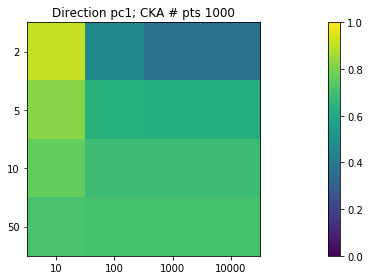

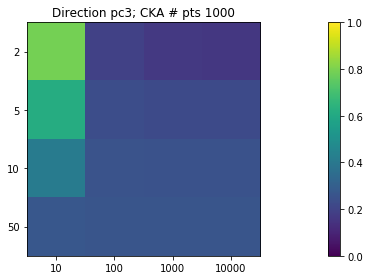

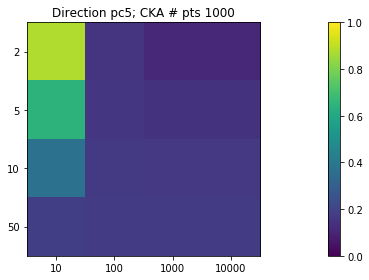

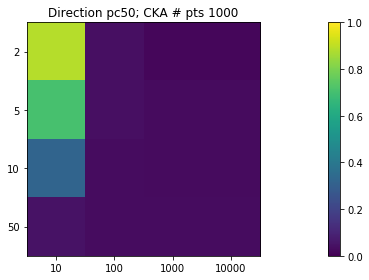

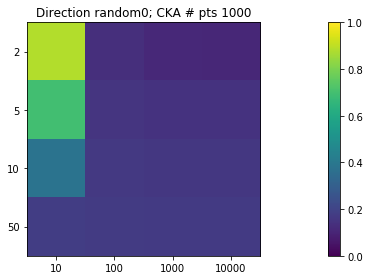

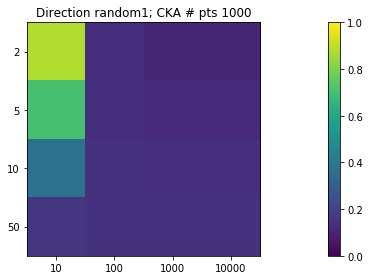

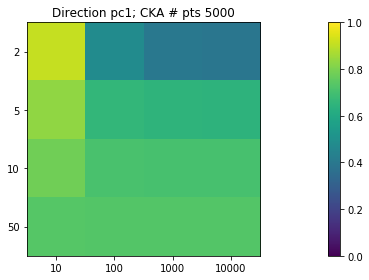

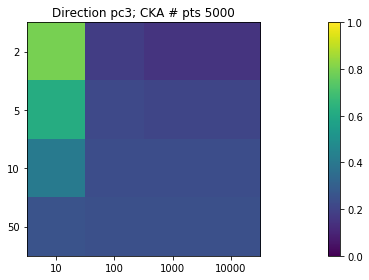

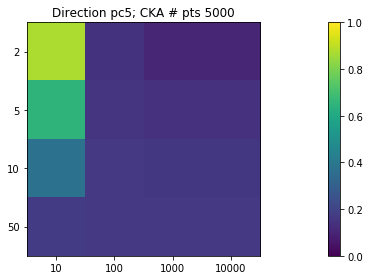

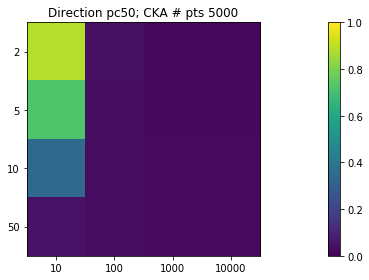

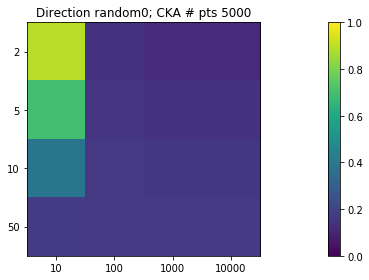

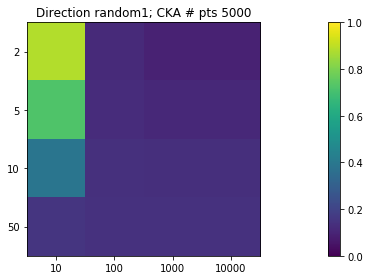

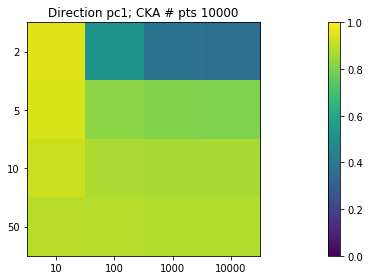

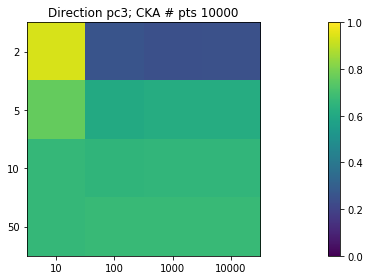

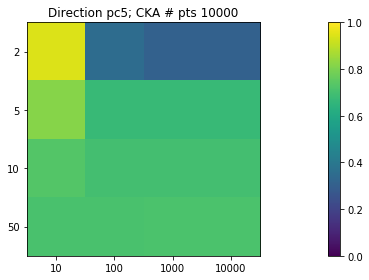

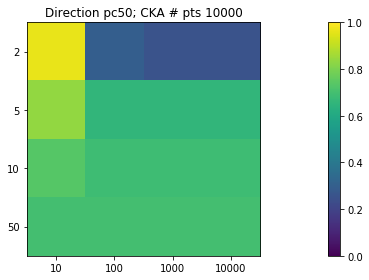

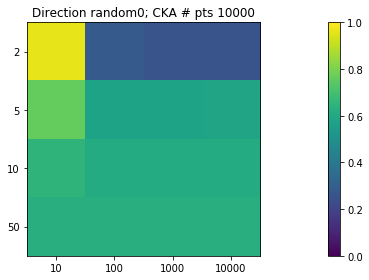

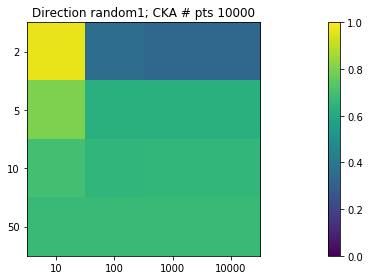

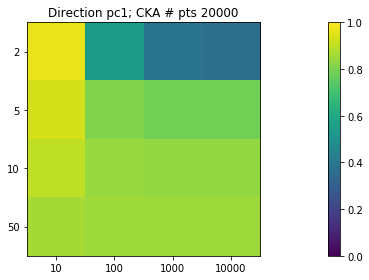

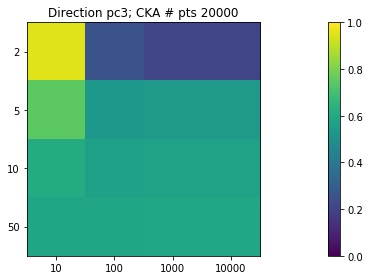

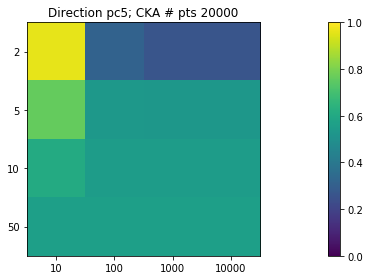

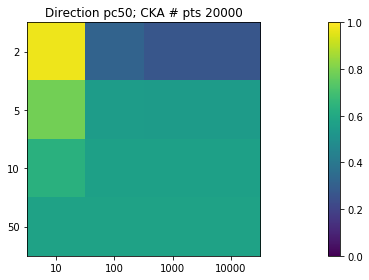

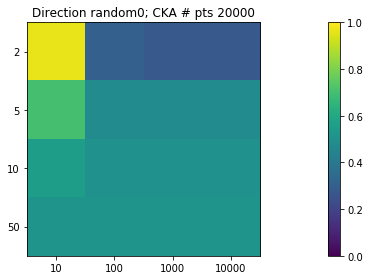

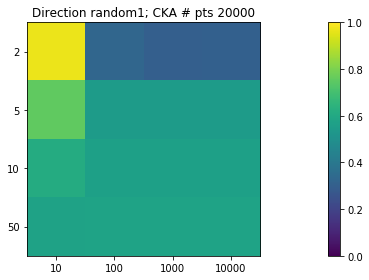

In [14]:
with open('data/split_class_exp_train_v1.pkl', 'rb') as f:
    data = pickle.load(f)
    
num_clusters = [2, 5, 10, 50]
dist_clusters = [10, 100, 1000, 10000]

for num_pts_cka in [1000, 5000, 10000, 20000]:
    for direction in ['pc10', 'pc30', 'pc50', 'pc500', 'random0', 'random1']:
        cka_values = np.array([[data[str(num_pts_cka)][direction][str(i)][str(j)]['cka'] for j in dist_clusters] for i in num_clusters])        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.imshow(cka_values, interpolation ='nearest', vmin=0, vmax=1)
        fig.colorbar(cax)
        dirr = direction[:-1]
        if 'random' in dirr: dirr = direction
        ax.set_title('Direction '+dirr+'; CKA # pts {}'.format(num_pts_cka))
        ax.set_xticks(np.arange(len(dist_clusters)))
        ax.set_yticks(np.arange(len(num_clusters)))
        ax.set_xticklabels([str(i) for i in dist_clusters])
        ax.set_yticklabels([str(i) for i in num_clusters])
        ax.axis('image')
        plt.tight_layout()
        plt.savefig('figures/split_exp_figures_v1/split_class_exp_train_{}pts_'.format(num_pts_cka)+dirr+'.png')